# These are some plots where h was a small value = 5 x 10^-15

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

In [34]:

import matplotlib.pyplot as plt 
from priors import priors_dict
import numpy as np 
import json
import pandas as pd 
import corner
import scienceplots

def load_data(path,variables_to_plot):


    try:
        df_posterior = pd.read_parquet(path)  

    except:
        # Opening JSON file
        f = open(path)
        data = json.load(f)
        f.close()
        #Make it a dataframe. 
        df_posterior = pd.DataFrame(data["posterior"]["content"]) 


    #Make omega into nHz
    df_posterior["omega_gw"] = df_posterior["omega_gw"]*1e9
    df_posterior["h"] = df_posterior["h"]*1e12

    y_post = df_posterior[variables_to_plot].to_numpy()

    # print("Number of samples:",len(df_posterior))
    # print("Truths/Medians/Variances")
    medians = df_posterior[variables_to_plot].median()
    variances = df_posterior[variables_to_plot].var()
    q = [0.05,0.95]
    for i in range(len(medians)):
        print(variables_to_plot[i],medians[i],variances[i])
        print("quantiles:", np.quantile(df_posterior[variables_to_plot[i]],q))
    



    return_code = 0


    extra_median = df_posterior['psi_gw'].median()
    #if extra_median < 1.0: #psi is weird / not converged so don't plot it 
       # print("Ignoring this file since psi not converged",extra_median)
       # return_code = 1
        
    print('-----------------------------***********************----------------------')
    return y_post, return_code







from parse import * 


def drop_braces(string_object):

    string_object = string_object.replace('{', '')
    string_object = string_object.replace('}', '')
    return string_object


def extract_value_from_title(title_string):

    template = '$\\{param_name}$ = ${value}_{lower}^{upper}$'

    parsed_output = parse(template, title_string)

    if parsed_output is None: #Handles h which is not a greek letter
        template = '${param_name}$ = ${value}_{lower}^{upper}$'
        parsed_output = parse(template, title_string)



    

    return parsed_output['param_name'],drop_braces(parsed_output['value']),drop_braces(parsed_output['lower']),drop_braces(parsed_output['upper'])

#https://stackoverflow.com/questions/32923605/is-there-a-way-to-get-the-index-of-the-median-in-python-in-one-command
def argmedian(x):
  return np.argpartition(x, len(x) // 2)[len(x) // 2]

def stacked_corner(list_of_files,number_of_files_to_plot,variables_to_plot,ranges,injection_parameters,labels,axes_scales,savefig=None,logscale=False):




    

    y = []
    fig= None 
    i = 0

    #while i < number_of_files_to_plot:

    for j in range(len(list_of_files)):
        f = list_of_files[j]
        yi,code = load_data(f,variables_to_plot)

        if code == 0:
            y.extend([yi])
            i += 1

        if i > number_of_files_to_plot:
            break
        
        print(i, f)

    plt.style.use('science')

    

    num_params = len(variables_to_plot)
    
    title_values = np.zeros((num_params,number_of_files_to_plot)) #an array with shape number of parameters x number of noise realisations 
    title_upper = np.zeros((num_params,number_of_files_to_plot)) 
    title_lower = np.zeros((num_params,number_of_files_to_plot))

    print("Shape of title value s arary", np.shape(title_values))
    

    for i in range(number_of_files_to_plot): #for each noise realisation 

        k = i 
        if k ==2:
            k = k+1 #convoluted way of skipping C2 color




        if logscale:
            yplot = np.log10(y[i])
            injection_parameters = np.log10(injection_parameters)
            #ranges = np.log10(ranges)
        else:
            yplot = y[i]
        
        print("ranges =", ranges)
        nsamples = len(y[i])
        fs = 20
        fig = corner.corner(yplot, 
                            color=f'C{k}',
                            show_titles=True,
                            smooth=True,smooth1d=True,
                            truth_color='C2',
                            quantiles=[0.16, 0.84],
                            truths =injection_parameters ,
                            range=ranges,
                            labels = labels,
                            label_kwargs=dict(fontsize=fs),
                            axes_scales = axes_scales,
                            weights = np.ones(nsamples)/nsamples,
                            fig=fig)


        kk = 0
        for ax in fig.axes:
            ax_title = ax.get_title()
            
            if ax_title != '':


                #print('2:', ax_title, type(ax_title))
                param_name, value,lower_limit,upper_limit = extract_value_from_title(ax_title) #Get the values that corner.corner sends to the ax title
                #print(parsed_output)

                print(kk,i,param_name,value)
                title_values[kk,i] = value
                title_lower[kk,i] = lower_limit
                title_upper[kk,i] = upper_limit


            
                kk += 1
                


        i += 1


        #Pretty-ify
    for ax in fig.axes:

        if ax.lines: #is anything plotted on this axis?
            
            ax.yaxis.set_major_locator(plt.MaxNLocator(3))
            ax.xaxis.set_major_locator(plt.MaxNLocator(3))

            ax.yaxis.set_tick_params(labelsize=fs-6)
            ax.xaxis.set_tick_params(labelsize=fs-6)


        ax.title.set_size(18)



    #Get the indices of the median values from the list of medians 
    idxs = [] #this is the index of the median for each parameter. 
    for l in range(num_params):
        idx = argmedian(title_values[l,:])
        idxs.extend([idx])



    #Now use it to set the titles
    kk = 0
    for ax in fig.axes:
        ax_title = ax.get_title()
        if ax_title != '':


            selected_idx = idxs[kk]

#foo = f'text$_{{{var}}}$'


            new_title_string = rf'{labels[kk]} $= {title_values[kk,selected_idx]:.2f}_{{{title_lower[kk,selected_idx]:.2f}}}^{{+{title_upper[kk,selected_idx]:.2f}}}$'
            print(new_title_string) 
            ax.set_title(new_title_string, fontsize=18)
            kk += 1





    if savefig != None:
        plt.savefig(f"../data/images/{savefig}.png", bbox_inches="tight",dpi=300)
        

    #return fig            


# Plot 1 result

omega_gw 499.16364555440316 1.031424858974595
phi0_gw 0.2689235032699961 0.026661702566708242
psi_gw 2.2330493885091287 0.10680156936526193
iota_gw 0.6471138759403542 0.09123791800962133
delta_gw 0.6877916136981507 0.007401669907335786
alpha_gw 0.6437657722972913 0.3097588017241692
h 0.003737492771815187 6.394127598234349e-07
Ignoring this file since psi not converged 2.2330493885091287
-----------------------------***********************----------------------
0 ../data/nested_sampling/data_for_manuscript/small_h_batch/small_h_model_earth_batch_1245_result.json
omega_gw 501.5593531912624 0.8232719162356221
phi0_gw 0.4707084043761159 0.02868546734160835
psi_gw 2.573164371096522 0.006718312959018406
iota_gw 0.6917683966191446 0.0985949859997171
delta_gw 0.9535516097902433 0.004165849956274011
alpha_gw 1.0582405632437115 0.006529222392304367
h 0.00548604783013375 1.4248506627747553e-06
-----------------------------***********************----------------------
1 ../data/nested_sampling/dat

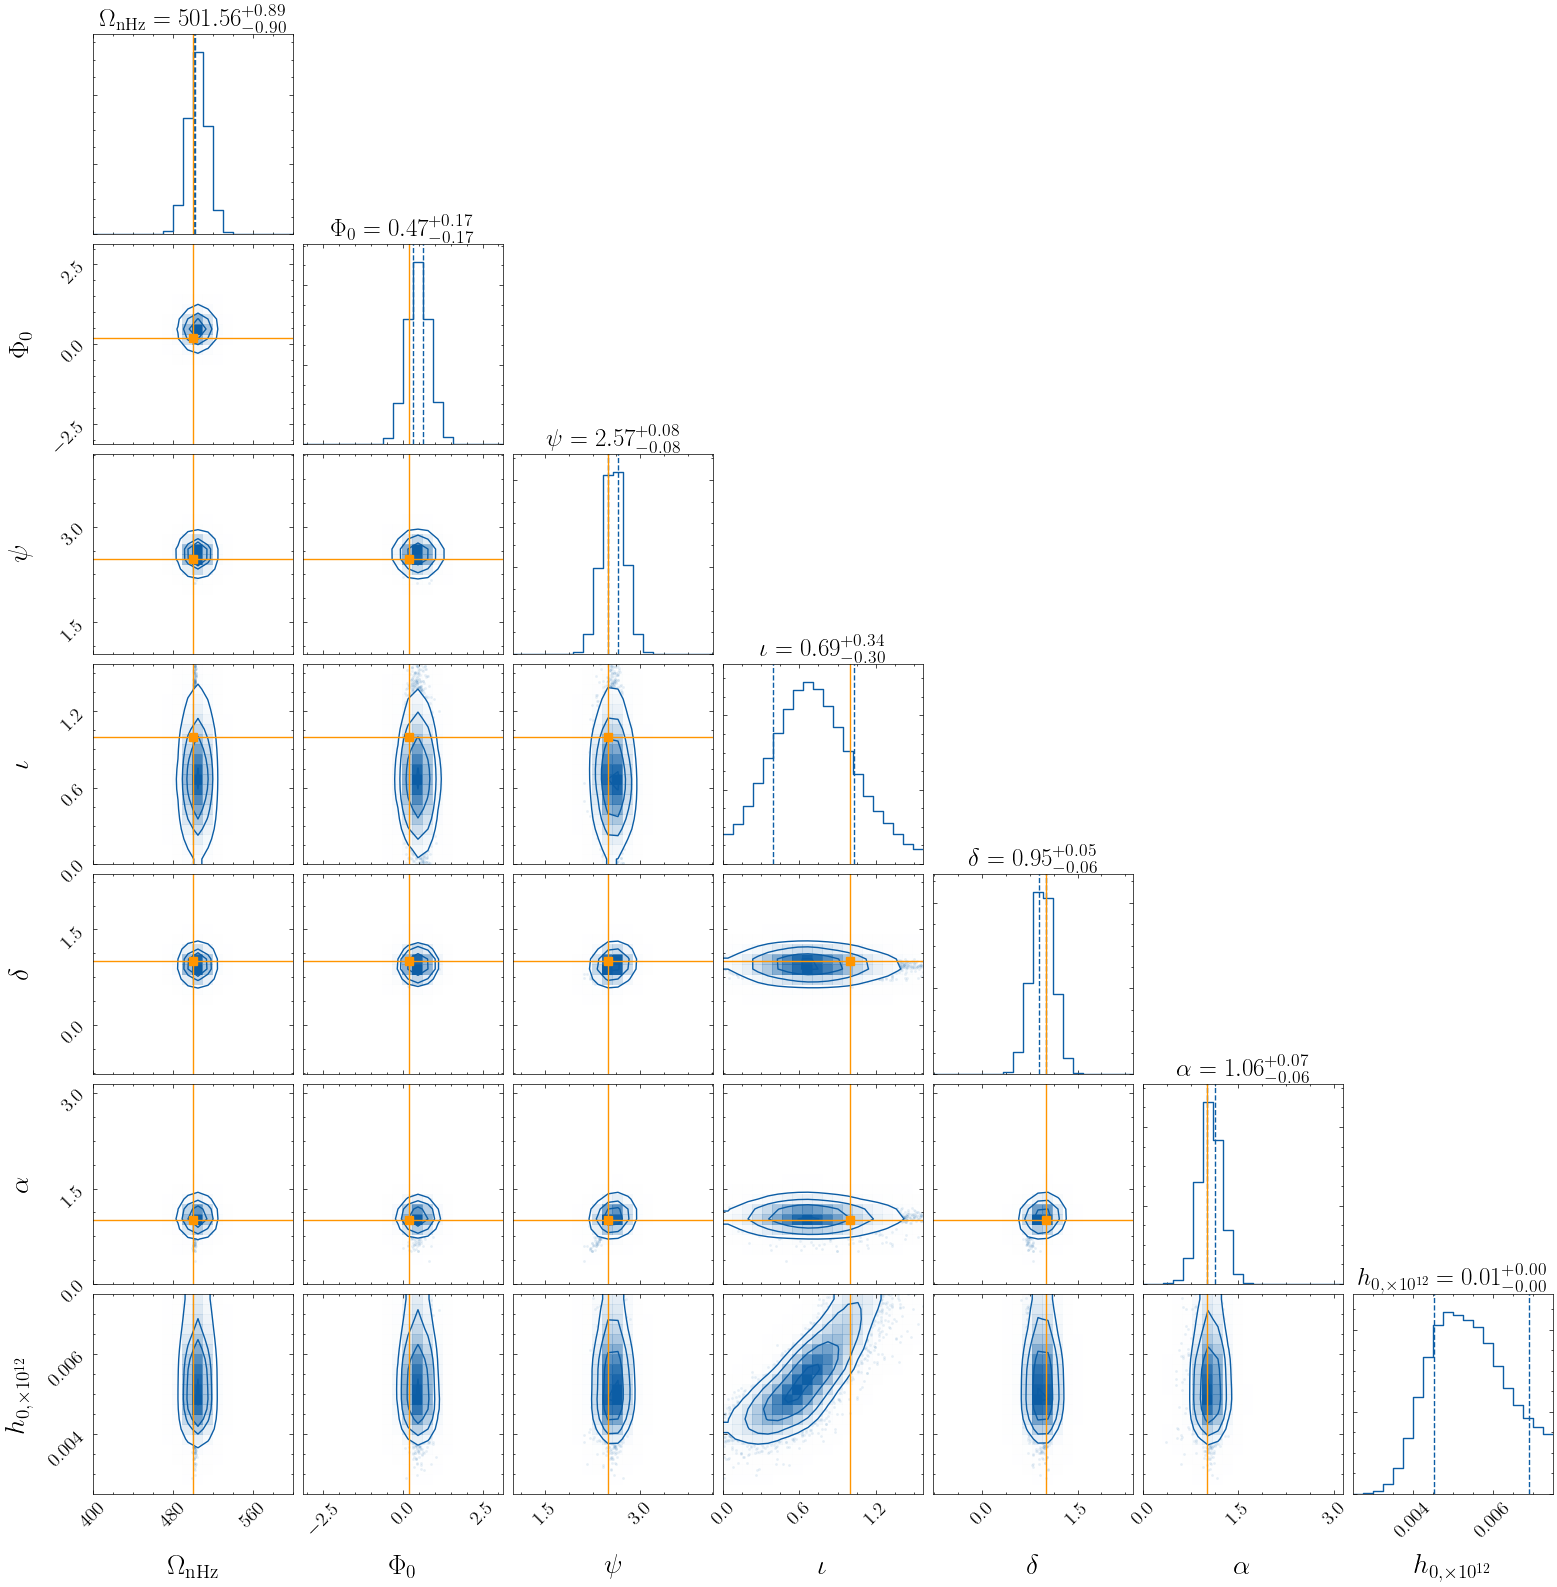

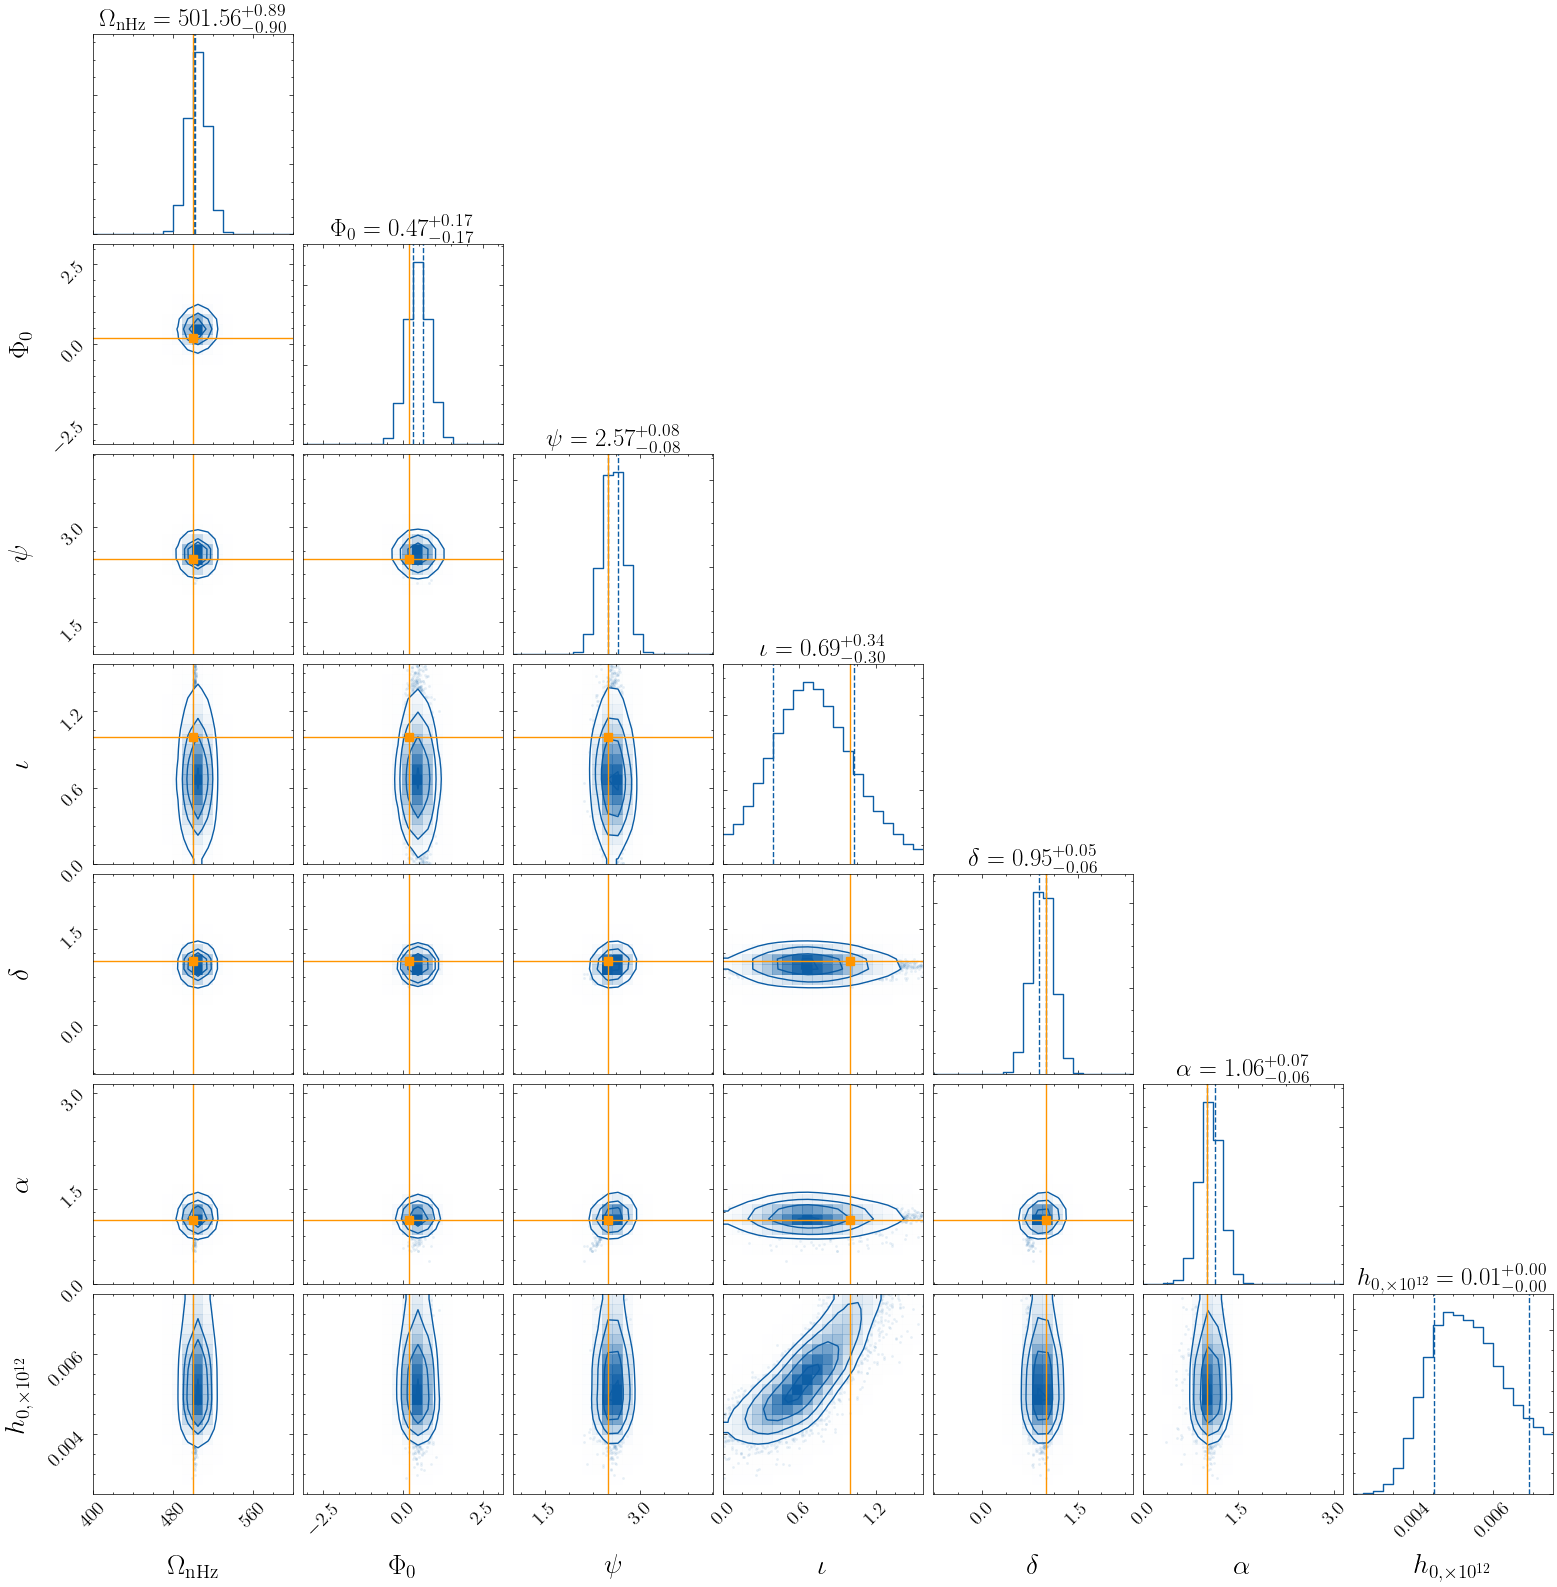

In [6]:
import glob 

list_of_files = sorted(glob.glob("../data/nested_sampling/data_for_manuscript/small_h_batch/*"))


variables_to_plot = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]

ranges=[(4e-7*1e9,6e-7*1e9),(-np.pi,np.pi),(0.0+1.0,np.pi+1.0),(0.0,np.pi/2.0),(-np.pi/2 + 0.8,np.pi/2 + 0.8),(0.0,np.pi),(0.005*0.5,0.005*1.5)]
injection_parameters = [5e-7*1e9,0.20,2.50,1.0,1.0,1.0,1e-12*1e12]
labels = [r'$\Omega_{\rm nHz}$',r'$\Phi_0$',r'$\psi$',r'$\iota$', r'$\delta$',r'$\alpha$',r'$h_{0, \times 10^{12}}$']
variables_to_plot = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]
axes_scales = None

number_of_files_to_plot = 1
stacked_corner(list_of_files,number_of_files_to_plot,variables_to_plot,ranges,injection_parameters,labels,axes_scales,savefig=None, logscale=False)

# Plot 5 results  

omega_gw 499.16364555440316 1.031424858974595
phi0_gw 0.2689235032699961 0.026661702566708242
psi_gw 2.2330493885091287 0.10680156936526193
iota_gw 0.6471138759403542 0.09123791800962133
delta_gw 0.6877916136981507 0.007401669907335786
alpha_gw 0.6437657722972913 0.3097588017241692
h 0.003737492771815187 6.394127598234349e-07
-----------------------------***********************----------------------
1 ../data/nested_sampling/data_for_manuscript/small_h_batch/small_h_model_earth_batch_1245_result.json
omega_gw 501.5593531912624 0.8232719162356221
phi0_gw 0.4707084043761159 0.02868546734160835
psi_gw 2.573164371096522 0.006718312959018406
iota_gw 0.6917683966191446 0.0985949859997171
delta_gw 0.9535516097902433 0.004165849956274011
alpha_gw 1.0582405632437115 0.006529222392304367
h 0.00548604783013375 1.4248506627747553e-06
-----------------------------***********************----------------------
2 ../data/nested_sampling/data_for_manuscript/small_h_batch/small_h_model_earth_batch_1246_

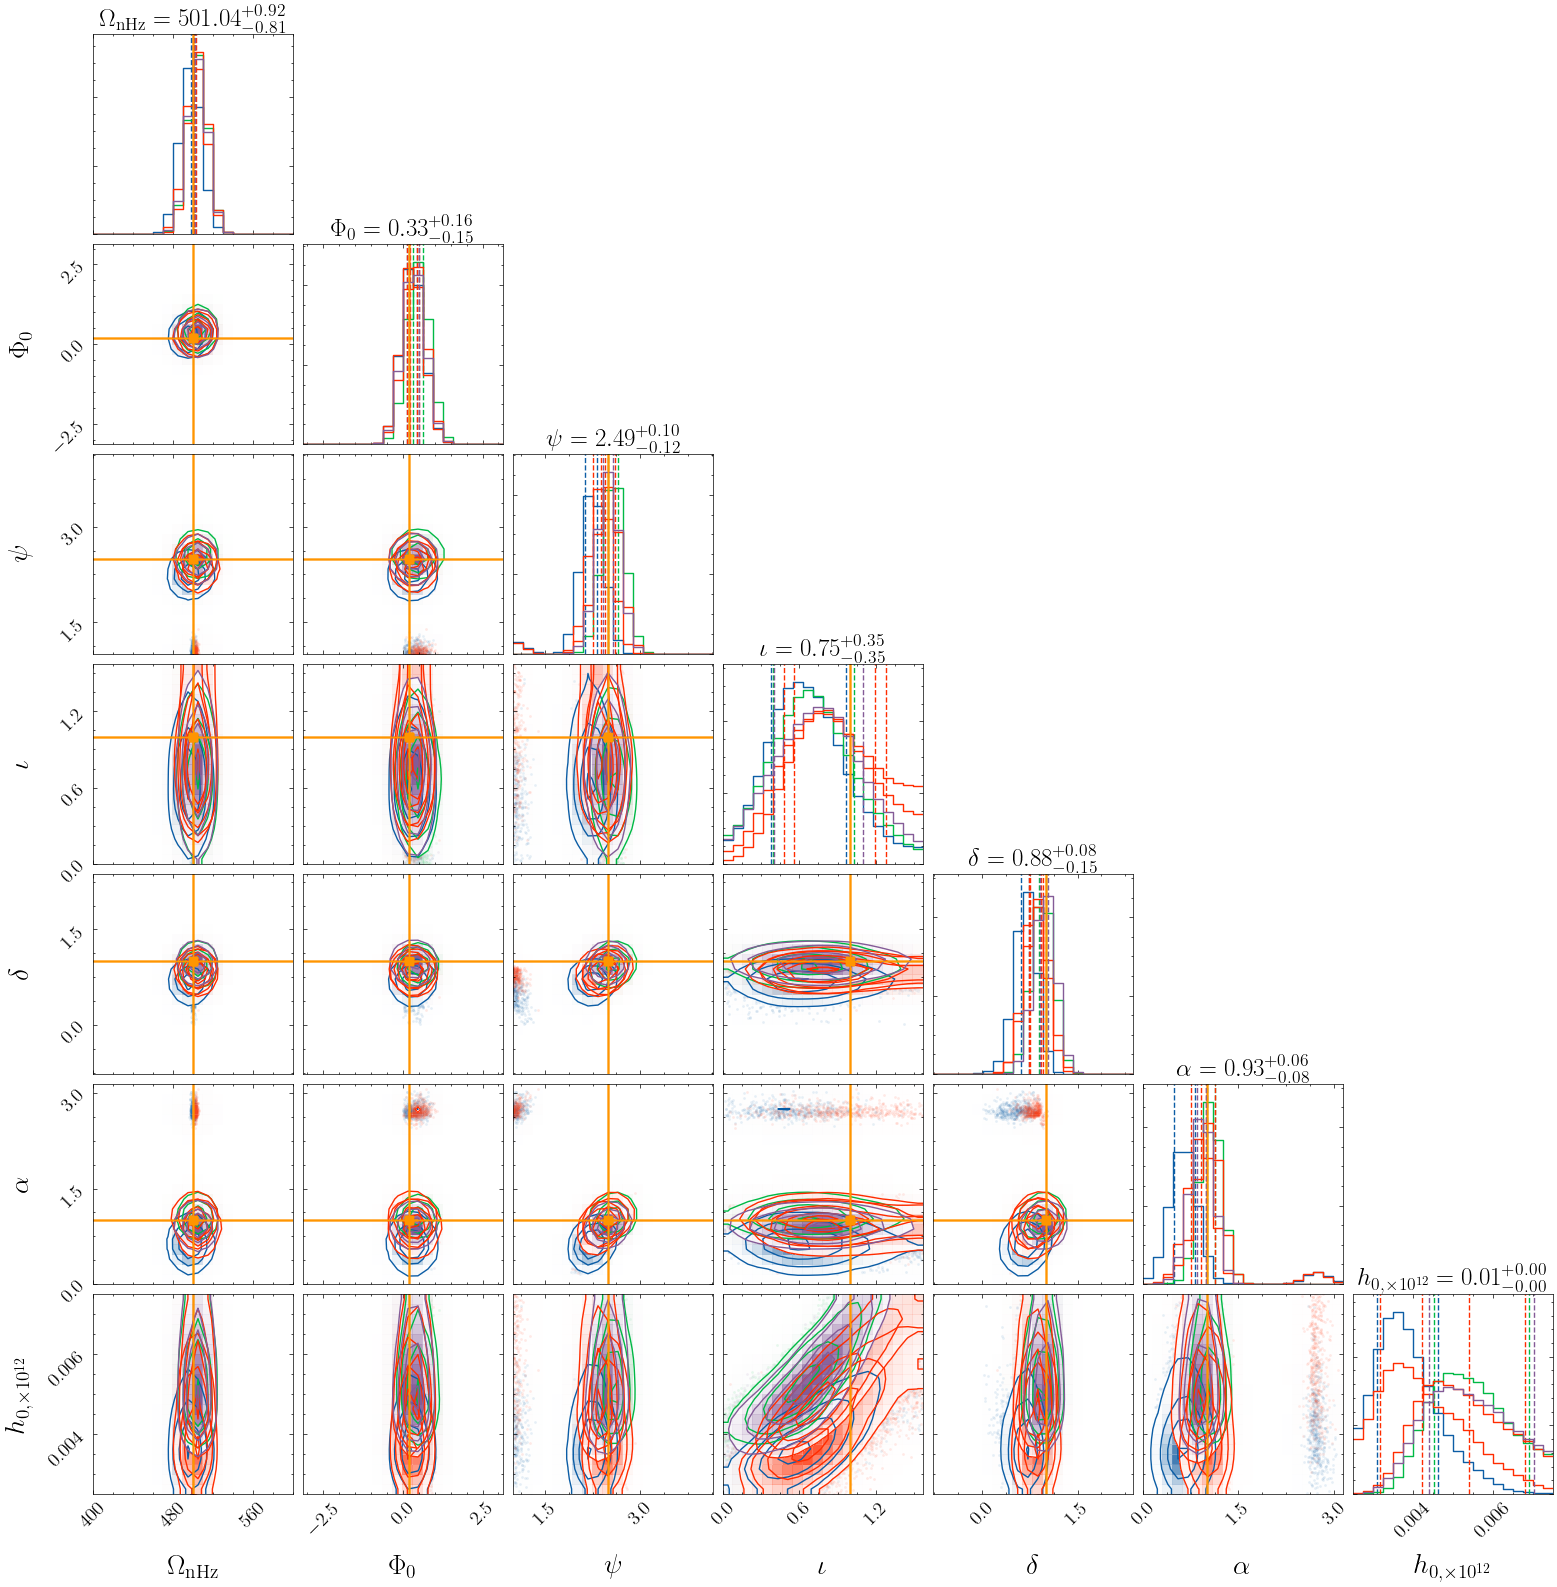

In [10]:
import glob 

list_of_files = sorted(glob.glob("../data/nested_sampling/data_for_manuscript/small_h_batch/*"))


variables_to_plot = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]

ranges=[(4e-7*1e9,6e-7*1e9),(-np.pi,np.pi),(0.0+1.0,np.pi+1.0),(0.0,np.pi/2.0),(-np.pi/2 + 0.8,np.pi/2 + 0.8),(0.0,np.pi),(0.005*0.5,0.005*1.5)]
injection_parameters = [5e-7*1e9,0.20,2.50,1.0,1.0,1.0,1e-12*1e12]
labels = [r'$\Omega_{\rm nHz}$',r'$\Phi_0$',r'$\psi$',r'$\iota$', r'$\delta$',r'$\alpha$',r'$h_{0, \times 10^{12}}$']
variables_to_plot = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]
axes_scales = None

number_of_files_to_plot = 5
stacked_corner(list_of_files,number_of_files_to_plot,variables_to_plot,ranges,injection_parameters,labels,axes_scales,savefig=None, logscale=False)

# Check the quantiles 

In [17]:
def check_quantiles(path,variable,q):
    # Opening JSON file
    f = open(path)
    data = json.load(f)
    f.close()
    #Make it a dataframe. 
    df_posterior = pd.DataFrame(data["posterior"]["content"]) 


    return np.quantile(df_posterior[variable],q)


In [27]:
path = "../data/nested_sampling/data_for_manuscript/small_h_batch/small_h_model_earth_batch_1247_result.json"

selected_variable = "omega_gw" 
q = [0.05,0.95]

check_quantiles(path,selected_variable,q)









array([4.9918288e-07, 5.0263971e-07])

In [23]:
list_of_files = sorted(glob.glob("../data/nested_sampling/data_for_manuscript/small_h_batch/*"))

truth_value = 5e-7


counts = 0
for f in list_of_files:

    quantiles = check_quantiles(f,selected_variable,q)
    if quantiles[0] <= truth_value <= quantiles[1]:
        counts += 1


print("Fraction in 90 per cent quantile =", counts / len(list_of_files))

Fraction in 90 per cent quantile = 0.78


# Plot a specific result

omega_gw 501.03776464991904 0.7658447061867991
quantiles: [499.73504093 502.62583189]
phi0_gw 0.3289544607259805 0.024737379358952583
quantiles: [0.08886653 0.61299876]
psi_gw 2.4955944854330028 0.007841046765499328
quantiles: [2.33709576 2.62083395]
iota_gw 0.7541596271652151 0.1101928885746697
quantiles: [0.20952373 1.33909175]
delta_gw 0.9797104342872976 0.0040818597684797635
quantiles: [0.84900077 1.06196749]
alpha_gw 0.9291962577152675 0.00867213572256479
quantiles: [0.73844307 1.03787752]
h 0.00548706361403627 1.6459794230489308e-06
quantiles: [0.00388118 0.00806662]
-----------------------------***********************----------------------
1 ../data/nested_sampling/data_for_manuscript/small_h_batch/small_h_model_earth_batch_1250_result.json
Shape of title value s arary (7, 1)
ranges = [(400.0, 600.0), (-3.141592653589793, 3.141592653589793), (1.0, 4.141592653589793), (0.0, 1.5707963267948966), (-0.7707963267948965, 2.3707963267948964), (0.0, 3.141592653589793), (0.0025, 0.0075)]

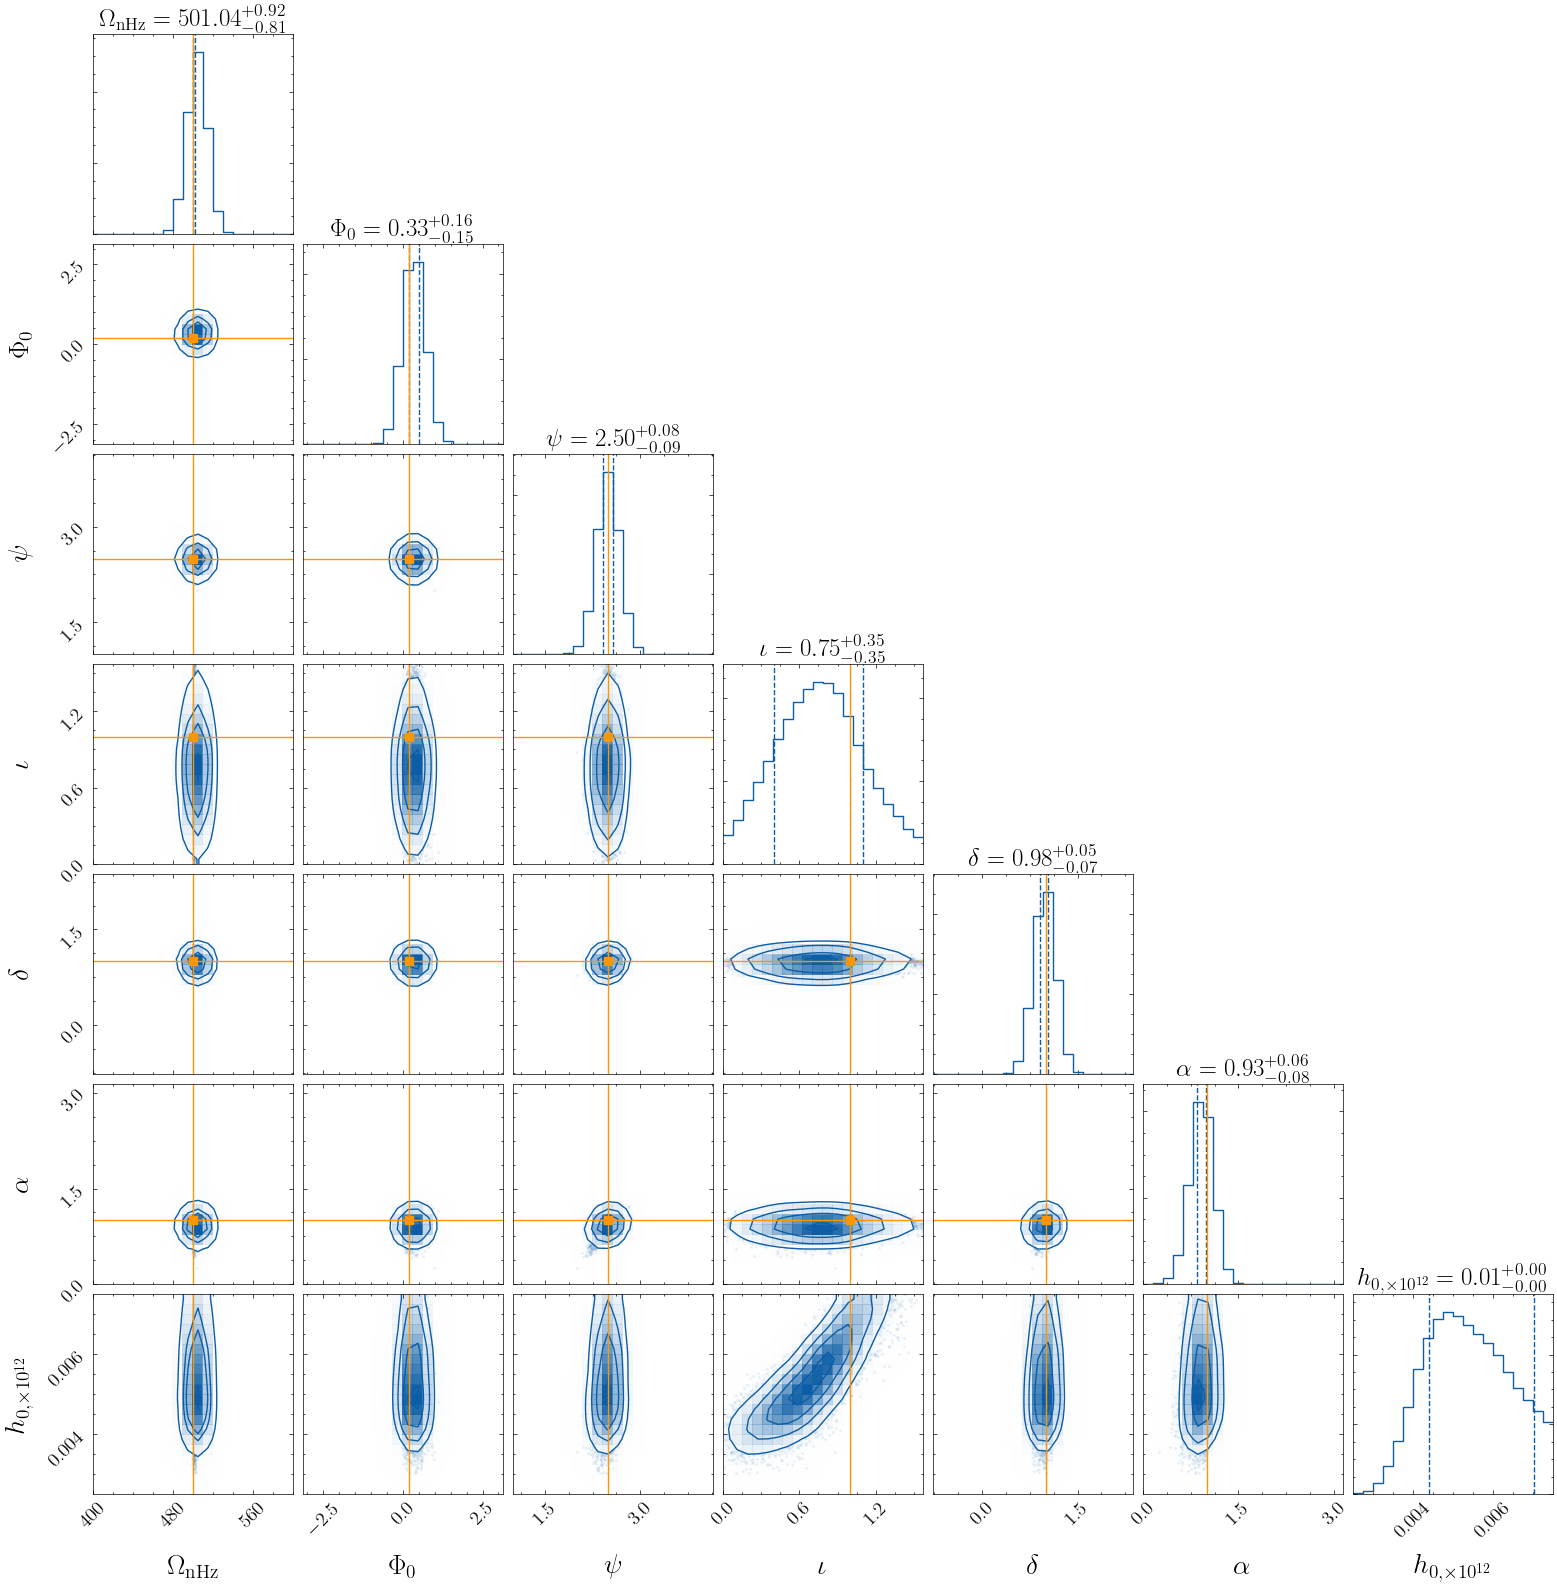

In [37]:
import glob 
list_of_files = ["../data/nested_sampling/data_for_manuscript/small_h_batch/small_h_model_earth_batch_1250_result.json"]

variables_to_plot = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]

ranges=[(4e-7*1e9,6e-7*1e9),(-np.pi,np.pi),(0.0+1.0,np.pi+1.0),(0.0,np.pi/2.0),(-np.pi/2 + 0.8,np.pi/2 + 0.8),(0.0,np.pi),(0.005*0.5,0.005*1.5)]
injection_parameters = [5e-7*1e9,0.20,2.50,1.0,1.0,1.0,1e-12*1e12]
labels = [r'$\Omega_{\rm nHz}$',r'$\Phi_0$',r'$\psi$',r'$\iota$', r'$\delta$',r'$\alpha$',r'$h_{0, \times 10^{12}}$']
variables_to_plot = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw", "h"]
axes_scales = None

number_of_files_to_plot = 1
stacked_corner(list_of_files,number_of_files_to_plot,variables_to_plot,ranges,injection_parameters,labels,axes_scales,savefig=None, logscale=False)